In [ ]:
!pip install mplsoccer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 kB 4.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from mplsoccer import PyPizza,Pitch,VerticalPitch,Sbopen

In [ ]:
base_dir = "/data/"

In [ ]:
df = pd.read_csv(f"{base_dir}3923881.csv")

In [ ]:
df =  df.drop(['id_x','pass_recipient_id','pass_recipient_id',
         'id_y','play_pattern_id','pass_height_id',
         'match_id_y','body_part_id','sub_type_id',
         'match_id_x','outcome_id','technique_id',
         'player_name_y','substitution_replacement_id',
         'goalkeeper_position_id','foul_committed_card_id',
         'position_id_y',
         'position_id_x',
         'position_name_y','type_id','team_id',
         'possession_team_id','event_tactics_id'
         ],\
        axis=1)
df = df.rename(columns={'player_name_x':'player_name',
                   'position_name_x':'position_name'})

In [ ]:
df.loc[(df['type_name']=='Pass')&(df['outcome_name'].isna()),'outcome_name'] = "Completed"

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)

In [ ]:
nigeria = df.loc[(df['team_name']=='Nigeria')&(df['pass_recipient_name'].isna()==False)]
ivory = df.loc[(df['team_name']=="Côte d'Ivoire")&(df['pass_recipient_name'].isna()==False)]

# Passing Network

In [ ]:
player_ngr = df[df['team_name']=='Nigeria'].groupby('player_name').agg({'minute':[min,max]}).reset_index()
player_ngr = pd.concat([player_ngr['player_name'],player_ngr['minute']],axis=1)
player_ngr['minute_played'] = player_ngr['max']-player_ngr['min']
player_ngr = player_ngr.sort_values('minute_played',ascending=False)

In [ ]:
player_ic = df[df['team_name']=="Côte d'Ivoire"].groupby('player_name').agg({'minute':[min,max]}).reset_index()
player_ic = pd.concat([player_ic['player_name'],player_ic['minute']],axis=1)
player_ic['minute_played'] = player_ic['max']-player_ic['min']
player_ic = player_ic.sort_values('minute_played',ascending=False)

In [ ]:
player_nigeria = player_ngr.player_name[:11].to_list()
player_ivory = player_ic.player_name[:11].to_list()

In [ ]:
ic = ivory[(ivory['pass_recipient_name'].isin(player_ivory)) & (ivory['player_name'].isin(player_ivory))]
ngr = nigeria[(nigeria['pass_recipient_name'].isin(player_nigeria))&(nigeria['player_name'].isin(player_nigeria))]

In [ ]:
scatter_df = pd.DataFrame()
for i, name in enumerate(ngr["player_name"].unique()):
    passx = ngr.loc[ngr["player_name"] == name]["x"].to_numpy()
    recx = ngr.loc[ngr["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = ngr.loc[ngr["player_name"] == name]["y"].to_numpy()
    recy = ngr.loc[ngr["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    #calculate number of passes
    scatter_df.at[i, "no"] = ngr.loc[ngr["player_name"] == name].count().iloc[0]
    scatter_df.at[i, "jersey_number"] = ngr.loc[ngr["player_name"] == name]['jersey_number'].iloc[0]
    scatter_df['jersey_number'] = scatter_df['jersey_number'].astype(int)

#adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1000)

In [ ]:
ngr["pair_key"] = ngr.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = ngr.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold
lines_df = lines_df[lines_df['pass_count']>5]

<ipython-input-41-d600d8542578>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngr["pair_key"] = ngr.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)


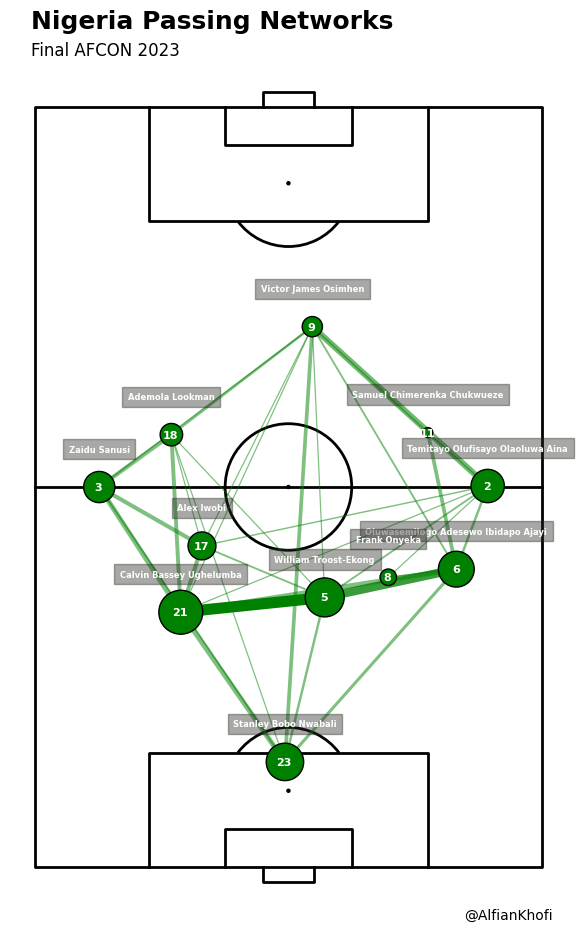

In [ ]:
pitch = VerticalPitch(pitch_type='statsbomb',pitch_color='white', line_color='black',linewidth=2,goal_type='box')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Plot vertices
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='green', edgecolors='#000000', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)

#Add Players Name and Jersey Numbers
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c='white', va='center',
                   ha='center', size=6, weight = "bold", ax=ax["pitch"], zorder = 4,
                   bbox=dict(facecolor='#272822', alpha=.40, edgecolor='#272822'))

for i, row in scatter_df.iterrows():
    pitch.annotate(row.jersey_number, xy=(row.x, row.y-0.1), c='white', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4)

#Plot edges
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1,'x']
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1,'y']
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2,'x']
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2,'y']
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 8)
        # adjust the alpha of the lines based on number of passes and set minimum alpha for a fewer pass
        alpha = max(num_passes / lines_df['pass_count'].max(), 0.2)
        alpha = max(alpha, 0.5)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="green", ax = ax["pitch"])

fig.text(s="Nigeria Passing Networks", x= 0.06, y= 1, fontsize=18,fontweight="bold")
fig.text(s='Final AFCON 2023', x = 0.06, y=0.97, fontsize=12)
fig.text(s='@AlfianKhofi', x = 0.80, y=0.01, fontsize=10)
plt.savefig(f'{base_dir}Nigeria_passing_network.png',bbox_inches='tight')
plt.show()

In [ ]:
scatter_df1 = pd.DataFrame()
for i, name in enumerate(ic["player_name"].unique()):
    passx = ic.loc[ic["player_name"] == name]["x"].to_numpy()
    recx = ic.loc[ic["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = ic.loc[ic["player_name"] == name]["y"].to_numpy()
    recy = ic.loc[ic["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df1.at[i, "player_name"] = name

    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df1.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df1.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    #calculate number of passes
    scatter_df1.at[i, "no"] = ic.loc[ic["player_name"] == name].count().iloc[0]
    scatter_df1.at[i, "jersey_number"] = ic.loc[ic["player_name"] == name]['jersey_number'].iloc[0]
    scatter_df1['jersey_number'] = scatter_df1['jersey_number'].astype(int)

#adjust the size of a circle so that the player who made more passes
scatter_df1['marker_size'] = (scatter_df1['no'] / scatter_df1['no'].max() * 1000)

In [ ]:
ic["pair_key"] = ic.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df1 = ic.groupby(["pair_key"]).x.count().reset_index()
lines_df1.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold
lines_df1 = lines_df1[lines_df1['pass_count']>5]

<ipython-input-45-7f4385c9573b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ic["pair_key"] = ic.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)


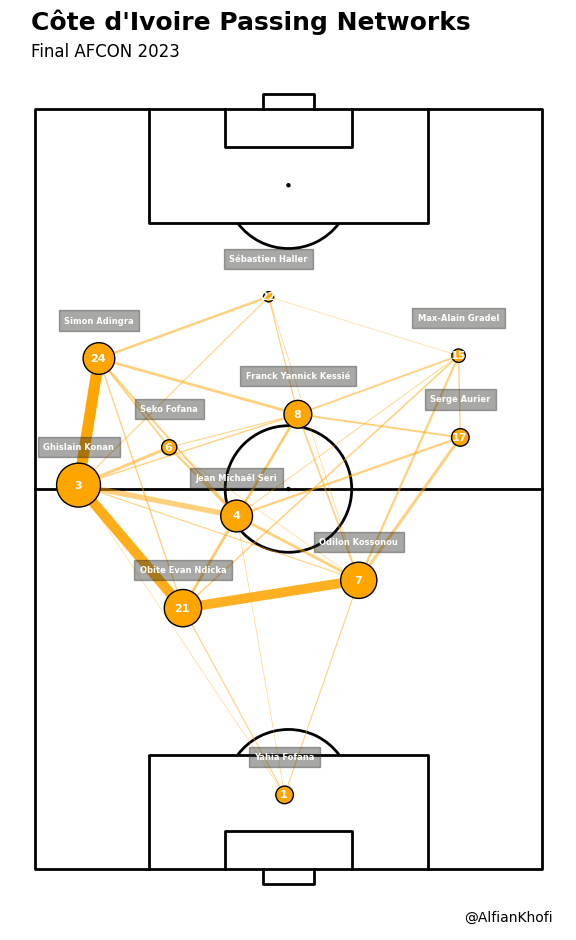

In [ ]:
pitch = VerticalPitch(pitch_type='statsbomb',pitch_color='white', line_color='black',linewidth=2,goal_type='box')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Plot vertices
pitch.scatter(scatter_df1.x, scatter_df1.y, s=scatter_df1.marker_size, color='orange', edgecolors='#000000', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)

#Add Players Name and Jersey Numbers
for i, row in scatter_df1.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c='white', va='center',
                   ha='center', size=6, weight = "bold", ax=ax["pitch"], zorder = 4,
                   bbox=dict(facecolor='#272822', alpha=.40, edgecolor='#272822'))

for i, row in scatter_df1.iterrows():
    pitch.annotate(row.jersey_number, xy=(row.x, row.y-0.1), c='white', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4)

#Plot edges
for i, row in lines_df1.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df1.loc[scatter_df1["player_name"] == player1,'x']
        player1_y = scatter_df1.loc[scatter_df1["player_name"] == player1,'y']
        player2_x = scatter_df1.loc[scatter_df1["player_name"] == player2,'x']
        player2_y = scatter_df1.loc[scatter_df1["player_name"] == player2,'y']
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df1['pass_count'].max() * 8)
        # adjust the alpha of the lines based on number of passes and set minimum alpha for a fewer pass
        alpha = max(num_passes / lines_df1['pass_count'].max(), 0.2)
        alpha = max(alpha, 0.5)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="orange", ax = ax["pitch"])

fig.text(s="Côte d'Ivoire Passing Networks", x= 0.06, y= 1, fontsize=18,fontweight="bold")
fig.text(s='Final AFCON 2023', x = 0.06, y=0.97, fontsize=12)
fig.text(s='@AlfianKhofi', x = 0.80, y=0.01, fontsize=10)
plt.savefig(f'{base_dir}Côte d\'Ivoire_passing_network.png',bbox_inches='tight')
plt.show()

# Shotmap

In [ ]:
from matplotlib.path import Path

vertices=[[ 1.86622681e+00, -9.69864442e+01], [-5.36324682e+01, -9.69864442e+01],
 [-9.86337733e+01, -5.19851396e+01], [-9.86337733e+01,  3.51356038e+00],
 [-9.86337733e+01,  5.90122504e+01], [-5.36324682e+01, 1.04013560e+02],
 [ 1.86622681e+00, 1.04013560e+02], [ 5.73649168e+01,  1.04013560e+02],
 [ 1.02366227e+02,  5.90122504e+01], [ 1.02366227e+02,  3.51356038e+00],
 [ 1.02366227e+02, -5.19851396e+01], [ 5.73649168e+01, -9.69864442e+01],
 [ 1.86622681e+00, -9.69864442e+01], [ 1.86622681e+00, -9.69864442e+01],
 [ 1.86622681e+00, -9.69864442e+01], [ 1.86622681e+00, -9.59864442e+01],
 [ 1.49396568e+01, -9.59864442e+01], [ 2.74005268e+01, -9.34457032e+01],
 [ 3.88349768e+01, -8.88614442e+01], [ 3.93477668e+01, -8.39473616e+01],
 [ 3.91766768e+01, -7.84211406e+01], [ 3.83349768e+01, -7.24551946e+01],
 [ 2.54705168e+01, -7.17582316e+01], [ 1.38598668e+01, -6.91771276e+01],
 [ 3.49122681e+00, -6.47364446e+01], [-5.88483119e+00, -7.07454276e+01],
 [-1.85084882e+01, -7.43878696e+01], [-3.31337732e+01, -7.44239446e+01],
 [-3.31639232e+01, -8.07006846e+01], [-3.34889082e+01, -8.56747886e+01],
 [-3.41025232e+01, -8.92676942e+01], [-2.29485092e+01, -9.35925582e+01],
 [-1.08166852e+01, -9.59864442e+01], [ 1.86622681e+00, -9.59864442e+01],
 [ 1.86622681e+00, -9.59864442e+01], [ 1.86622681e+00, -9.59864442e+01],
 [ 3.98974768e+01, -8.84239444e+01], [ 6.30273268e+01, -7.88377716e+01],
 [ 8.17782368e+01, -6.07995616e+01], [ 9.22412268e+01, -3.81426946e+01],
 [ 8.94287268e+01, -3.42676946e+01], [ 8.27048568e+01, -3.89413496e+01],
 [ 7.41977468e+01, -4.19580876e+01], [ 6.55537268e+01, -4.39551946e+01],
 [ 6.55507268e+01, -4.39600946e+01], [ 6.55258268e+01, -4.39502946e+01],
 [ 6.55225268e+01, -4.39551946e+01], [ 5.64622368e+01, -5.74584576e+01],
 [ 4.77347768e+01, -6.68825886e+01], [ 3.93037768e+01, -7.22051946e+01],
 [ 4.01409768e+01, -7.80795846e+01], [ 4.03596968e+01, -8.35092576e+01],
 [ 3.98975268e+01, -8.84239444e+01], [ 3.98974768e+01, -8.84239444e+01],
 [ 3.98974768e+01, -8.84239444e+01], [-3.33525232e+01, -7.34239446e+01],
 [-3.33343532e+01, -7.34304446e+01], [-3.33081932e+01, -7.34174446e+01],
 [-3.32900232e+01, -7.34239446e+01], [-1.87512102e+01, -7.34136546e+01],
 [-6.26111319e+00, -6.98403626e+01], [ 2.95997681e+00, -6.39239446e+01],
 [ 4.88356681e+00, -5.29429786e+01], [ 6.50358681e+00, -4.13393356e+01],
 [ 7.80372681e+00, -2.91114446e+01], [-8.09469019e+00, -1.58596306e+01],
 [-1.93481942e+01, -5.40333762e+00], [-2.47587732e+01,  1.32605538e+00],
 [-3.69631432e+01, -2.50275662e+00], [-4.85465082e+01, -5.39578762e+00],
 [-5.95087732e+01, -7.36144462e+00], [-6.28171902e+01, -1.66250136e+01],
 [-6.52187002e+01, -2.98372096e+01], [-6.58837732e+01, -4.57989446e+01],
 [-5.53582062e+01, -6.01863506e+01], [-4.45266302e+01, -6.94131916e+01],
 [-3.33525232e+01, -7.34239446e+01], [-3.33525232e+01, -7.34239446e+01],
 [-3.33525232e+01, -7.34239446e+01], [-7.57587732e+01, -4.67676946e+01],
 [-7.29041812e+01, -4.67440446e+01], [-6.99334012e+01, -4.63526666e+01],
 [-6.68837732e+01, -4.56426946e+01], [-6.62087282e+01, -2.96768106e+01],
 [-6.37905682e+01, -1.64255576e+01], [-6.04462732e+01, -7.04894462e+00],
 [-6.81326882e+01,  3.32535038e+00], [-7.26804032e+01,  1.40097104e+01],
 [-7.40712732e+01,  2.50135604e+01], [-7.99916232e+01,  2.63222104e+01],
 [-8.66133452e+01,  2.67559804e+01], [-9.31650233e+01,  2.54510604e+01],
 [-9.31681733e+01,  2.54460604e+01], [-9.31931223e+01,  2.54560604e+01],
 [-9.31962733e+01,  2.54510604e+01], [-9.44043873e+01,  2.37123804e+01],
 [-9.54279373e+01,  2.17334704e+01], [-9.63212733e+01,  1.95448104e+01],
 [-9.71662733e+01,  1.43262704e+01], [-9.76337733e+01,  8.97093038e+00],
 [-9.76337733e+01,  3.51356038e+00], [-9.76337733e+01, -1.43647536e+01],
 [-9.29174773e+01, -3.11438126e+01], [-8.46650232e+01, -4.56426946e+01],
 [-8.18063532e+01, -4.64180796e+01], [-7.88476312e+01, -4.67932816e+01],
 [-7.57587732e+01, -4.67676946e+01], [-7.57587732e+01, -4.67676946e+01],
 [-7.57587732e+01, -4.67676946e+01], [ 6.55224768e+01, -4.28926946e+01],
 [ 7.40107668e+01, -4.09146326e+01], [ 8.23640768e+01, -3.79999686e+01],
 [ 8.88662268e+01, -3.34864446e+01], [ 9.61553068e+01, -1.55950616e+01],
 [ 9.94808868e+01, -1.66158462e+00], [ 9.88662268e+01,  8.32606038e+00],
 [ 9.42289868e+01,  2.15752904e+01], [ 8.77410868e+01,  3.15965604e+01],
 [ 8.11474768e+01,  3.82010604e+01], [ 7.17659368e+01,  3.38334104e+01],
 [ 6.38899668e+01,  3.03415204e+01], [ 5.74912268e+01,  2.77635604e+01],
 [ 5.68036568e+01,  1.50717604e+01], [ 5.35581368e+01, -9.16606169e-02],
 [ 4.82412268e+01, -1.60489446e+01], [ 5.52234668e+01, -2.62259056e+01],
 [ 6.09897268e+01, -3.51652306e+01], [ 6.55224768e+01, -4.28926946e+01],
 [ 6.55224768e+01, -4.28926946e+01], [ 6.55224768e+01, -4.28926946e+01],
 [ 8.42872681e+00, -2.83614446e+01], [ 2.13772368e+01, -2.57261866e+01],
 [ 3.43239568e+01, -2.15154036e+01], [ 4.72724768e+01, -1.57364446e+01],
 [ 5.25849968e+01,  2.07647383e-01], [ 5.58247068e+01,  1.53619304e+01],
 [ 5.64912268e+01,  2.79510604e+01], [ 5.64917568e+01,  2.79612604e+01],
 [ 5.64906868e+01,  2.79721604e+01], [ 5.64912268e+01,  2.79822604e+01],
 [ 4.74302668e+01,  3.88992704e+01], [ 3.74260968e+01,  4.79380604e+01],
 [ 2.64912268e+01,  5.51072604e+01], [ 1.05529568e+01,  5.24508804e+01],
 [-4.02431919e+00,  4.78459804e+01], [-1.52900232e+01,  4.18885104e+01],
 [-1.91554652e+01,  2.63828404e+01], [-2.20678242e+01,  1.30703504e+01],
 [-2.40400232e+01,  1.98226038e+00], [-1.87588732e+01, -4.60782062e+00],
 [-7.49875919e+00, -1.50853886e+01], [ 8.42872681e+00, -2.83614946e+01],
 [ 8.42872681e+00, -2.83614446e+01], [ 8.42872681e+00, -2.83614446e+01],
 [ 9.97724768e+01,  8.82606038e+00], [ 1.01209977e+02,  9.29481038e+00],
 [ 9.97891268e+01,  3.41125404e+01], [ 8.92576668e+01,  5.64775904e+01],
 [ 7.29287268e+01,  7.31385604e+01], [ 7.01162268e+01,  7.01073104e+01],
 [ 7.65398468e+01,  5.90945204e+01], [ 8.04306168e+01,  4.87012104e+01],
 [ 8.18037268e+01,  3.89510604e+01], [ 8.85060268e+01,  3.22487504e+01],
 [ 9.50869868e+01,  2.21436404e+01], [ 9.97724768e+01,  8.82606038e+00],
 [ 9.97724768e+01,  8.82606038e+00], [ 9.97724768e+01,  8.82606038e+00],
 [-7.39150232e+01,  2.60448104e+01], [-6.92374072e+01,  3.77382804e+01],
 [-6.07391432e+01,  4.81501604e+01], [-4.84150232e+01,  5.72948104e+01],
 [-4.77543102e+01,  6.78197404e+01], [-4.56607662e+01,  7.76814004e+01],
 [-4.11025232e+01,  8.57010604e+01], [-4.52341512e+01,  8.65620704e+01],
 [-4.97579362e+01,  8.64646604e+01], [-5.46650232e+01,  8.53885604e+01],
 [-7.24317802e+01,  7.30970204e+01], [-8.60276902e+01,  5.51787904e+01],
 [-9.28212733e+01,  3.42010604e+01], [-9.28243733e+01,  3.41920604e+01],
 [-9.28181733e+01,  3.41792604e+01], [-9.28212733e+01,  3.41698604e+01],
 [-9.30130013e+01,  3.14875704e+01], [-9.31144113e+01,  2.89274504e+01],
 [-9.31337733e+01,  2.64511104e+01], [-8.65119202e+01,  2.77331304e+01],
 [-7.98647022e+01,  2.73522904e+01], [-7.39150232e+01,  2.60448604e+01],
 [-7.39150232e+01,  2.60448104e+01], [-7.39150232e+01,  2.60448104e+01],
 [-1.56650232e+01,  4.27948104e+01], [-4.35766519e+00,  4.87636404e+01],
 [ 1.01466668e+01,  5.33700304e+01], [ 2.60224768e+01,  5.60448104e+01],
 [ 2.85590568e+01,  6.43435004e+01], [ 3.07827468e+01,  7.29492504e+01],
 [ 3.27099768e+01,  8.18573104e+01], [ 2.55039768e+01,  9.03537704e+01],
 [ 1.39714968e+01,  9.64983204e+01], [-1.13376819e+00,  9.85135604e+01],
 [-1.57753392e+01,  9.71825004e+01], [-2.87516412e+01,  9.28553404e+01],
 [-4.00712732e+01,  8.55448104e+01], [-4.46513912e+01,  7.76614604e+01],
 [-4.67507882e+01,  6.78133804e+01], [-4.74150232e+01,  5.72323104e+01],
 [-3.59060892e+01,  5.27285604e+01], [-2.53218622e+01,  4.79159104e+01],
 [-1.56650232e+01,  4.27948104e+01], [-1.56650232e+01,  4.27948104e+01],
 [ 6.94599768e+01,  7.08573104e+01], [ 7.22412268e+01,  7.38573104e+01],
 [ 5.42332468e+01,  9.18657304e+01], [ 2.93485768e+01,  1.03013560e+02],
 [ 1.86622681e+00,  1.03013560e+02], [ 1.03891181e+00,  1.03013560e+02],
 [ 2.19951808e-01,  1.03002360e+02], [-6.02518192e-01,  1.02982360e+02],
 [-1.00876819e+00,  9.94823604e+01], [ 1.43154268e+01,  9.74387404e+01],
 [ 2.60994568e+01,  9.12180804e+01], [ 3.34912268e+01,  8.24823604e+01],
 [ 4.89375568e+01,  8.17496704e+01], [ 6.09313968e+01,  7.78789204e+01],
 [ 6.94599768e+01,  7.08573604e+01], [ 6.94599768e+01,  7.08573104e+01],
 [ 6.94599768e+01,  7.08573104e+01]]




codes=[1,4,4,4,4,4,4,4,4,4,4,4,4,2,79,
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,79,
1,4,4,4,2,4,4,4,4,4,4,4,4,4,4,4,4,2,79,
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,79,
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,79,
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,79,
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,79,
1,2,4,4,4,2,4,4,4,4,4,4,2,79,
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,79,
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,79,
1,2,4,4,4,4,4,4,2,4,4,4,4,4,4,2, 79]
print(Path.MOVETO,Path.LINETO,Path.CURVE3,Path.CURVE4,Path.CLOSEPOLY)
ball=Path(vertices,codes)

1 2 3 4 79


In [ ]:
shot = df[df['type_name']=='Shot'].drop_duplicates().reset_index(drop=True)

In [ ]:
a_xg = [0]
h_xg = [0]
a_min = [0]
h_min = [0]

a_team = 'Nigeria'
h_team = "Côte d'Ivoire"

for m in range(len(shot['shot_statsbomb_xg'])):
  if shot['team_name'][m] == a_team:
    a_xg.append(shot['shot_statsbomb_xg'][m])
    a_min.append(shot['minute'][m])
  if shot['team_name'][m] == h_team:
    h_xg.append(shot['shot_statsbomb_xg'][m])
    h_min.append(shot['minute'][m])

In [ ]:
def cek(listA,listB):
  if listA[-1] <= 90:
    for w in range(listA[-1]+1,105,15):
      if w >= 90:
        listA.append(90)
      else:
        listA.append(w)
  if listB[-1] <= 90:
    for g in range(listB[-1]+1,105,15):
      if g >= 90:
        listB.append(90)
      else:
        listB.append(g)

def cek_xg(listxg,listmin):
  while len(listxg) < len(listmin):
   listxg.append(0)

def equal(list1,list2):
  if max(list1) > max(list2):
    list2.append(max(list1))
  if max(list1) < max(list2):
    list1.append(max(list2))
equal(a_min,h_min)

In [ ]:
cek(h_min,a_min)
cek_xg(a_xg,a_min)
cek_xg(h_xg,h_min)

In [ ]:
def cumulative_sum(num_list):
  return [sum(num_list[:i+1]) for i in range(len(num_list))]
a_cumulative = cumulative_sum(a_xg)
h_cumulative = cumulative_sum(h_xg)

In [ ]:
xg_away = {k:v for k,v in zip(a_min,a_cumulative)}

In [ ]:
xg_home = {k:v for k,v in zip(h_min,h_cumulative)}

In [ ]:
goal = shot[shot['outcome_name']=='Goal']

In [ ]:
goal = goal.drop_duplicates()

In [ ]:
a_goal = goal.loc[goal["team_name"]=="Côte d\'Ivoire","outcome_name"].count()
h_goal = goal.loc[goal["team_name"]=="Nigeria","outcome_name"].count()

In [ ]:
goal = goal.reset_index(drop=True)

In [ ]:
shot['xg'] = np.where(shot['team_name']=="Côte d'Ivoire",-shot['shot_statsbomb_xg'],shot['shot_statsbomb_xg'])

In [ ]:
ic_xg1 = shot.loc[(shot['period']==1)&(shot['team_name']=="Côte d'Ivoire"),['minute','shot_statsbomb_xg']]
ic_xg2 = shot.loc[(shot['period']==2)&(shot['team_name']=="Côte d'Ivoire"),['minute','shot_statsbomb_xg']]
ngr_xg1 = shot.loc[(shot['period']==1)&(shot['team_name']=="Nigeria"),['minute','shot_statsbomb_xg']]
ngr_xg2 = shot.loc[(shot['period']==2)&(shot['team_name']=="Nigeria"),['minute','shot_statsbomb_xg']]


In [ ]:
xg_ic = pd.concat([ic_xg1,ic_xg2],axis=0)
xg_ic['xg'] = cumulative_sum(xg_ic['shot_statsbomb_xg'])
xg_ngr = pd.concat([ngr_xg1,ngr_xg2],axis=0)
xg_ngr['xg'] = cumulative_sum(xg_ngr['shot_statsbomb_xg'])

In [ ]:
xg_ngr

,minute,shot_statsbomb_xg,xg
8,36,0.033672,0.033672
9,37,0.068359,0.102031
17,67,0.088091,0.190122
20,89,0.052508,0.242630
22,95,0.015563,0.258193


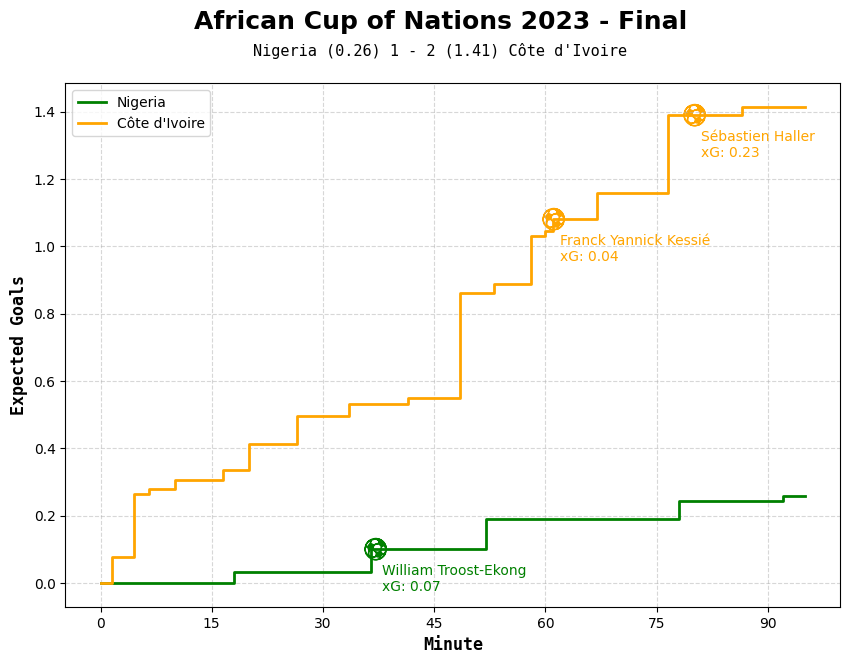

In [ ]:
fig, ax, = plt.subplots(figsize=(10,6.8))
ax.step(x=a_min, y=a_cumulative, color='green',where='mid',lw=2)
ax.step(x=h_min, y=h_cumulative, color='orange',where='mid',lw=2)
ax.grid(linestyle='--',alpha=.5)
fig.text(0.5,.92,f"Nigeria ({round(max(a_cumulative),2)}) {h_goal} - {a_goal} ({round(max(h_cumulative),2)}) Côte d\'Ivoire",\
         ha="center",\
         fontsize=11,\
         fontfamily='monospace')

fig.text(s='African Cup of Nations 2023 - Final',x=.5,y=.96,fontsize=18,ha='center',fontweight="bold",)
for x in range(len(goal['shot_statsbomb_xg'])):
  if goal['team_name'][x]==a_team:
    plt.scatter(x=goal['minute'][x],y=xg_away[goal['minute'][x]],s=250,c='green',alpha=1,marker=ball)
    plt.annotate(f"{goal['player_name'][x]}\nxG: {round(goal['shot_statsbomb_xg'][x],2)}",\
                xy=(goal['minute'][x]+1,xg_away[goal['minute'][x]]-.125),
                color='green')
  if goal['team_name'][x]==h_team:
    plt.scatter(x=goal['minute'][x],y=xg_home[goal['minute'][x]],s=250,c='orange',alpha=1,marker=ball)
    plt.annotate(f"{goal['player_name'][x]}\nxG: {round(goal['shot_statsbomb_xg'][x],2)}",\
            xy=(goal['minute'][x]+1,xg_home[goal['minute'][x]]-.125),
            color='orange')




plt.legend(['Nigeria',"Côte d\'Ivoire"])
plt.xticks([0,15,30,45,60,75,90])
plt.ylabel('Expected Goals',fontsize=12,fontfamily='monospace',fontweight='bold')
plt.xlabel('Minute',fontsize=12,fontfamily='monospace',fontweight='bold')
# plt.savefig(f'{base_dir}xg_final_afcon.png',bbox_inches='tight')
plt.show()

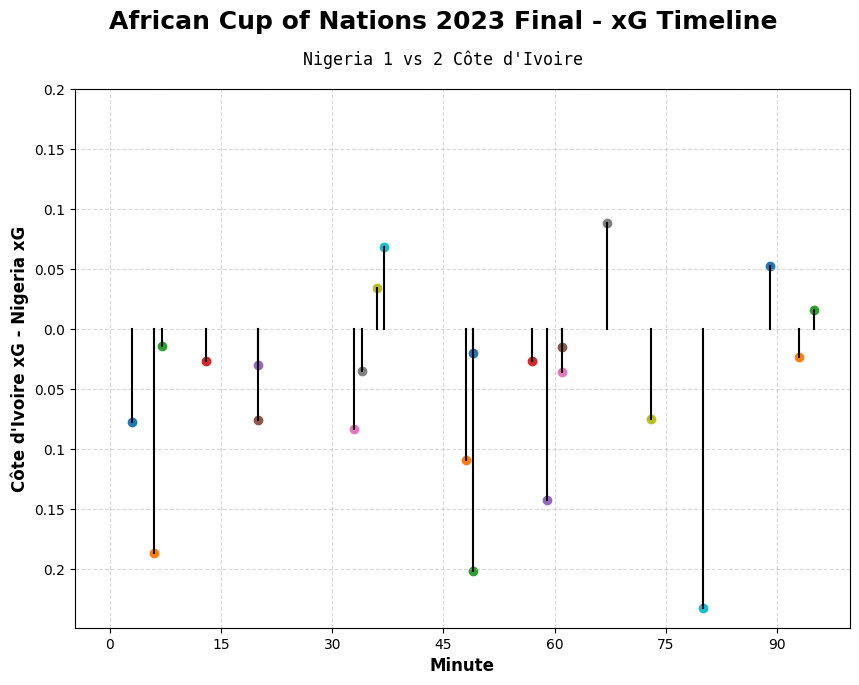

In [ ]:
plt.figure(figsize=(10,7))
plt.grid(linestyle='--',alpha=.5)
plt.text(x=45,y=0.25,s='African Cup of Nations 2023 Final - xG Timeline',fontsize=18,fontweight='bold',ha='center')
plt.text(x=45,y=0.22,s="Nigeria 1 vs 2 Côte d'Ivoire",fontsize=12,fontfamily='monospace',ha='center')
for i in range(len(shot)):
    x = shot['minute'][i]
    y = shot['xg'][i]
    plt.scatter(x, y, marker = 'o')

    # V this adds the lines V
    plt.plot([x,x], [0, y], color="black")
    # ^ this adds the lines ^

    plt.plot(x,y,0,0, linestyle = '--' )
plt.yticks(ticks = [-0.20,-.15,-.10,-.05,0.0,0.05,.10,.15,.20], labels=[0.20,.15,.10,.05,0.0,0.05,.10,.15,.20])
plt.xticks([a for a in range(0,105,15)])
plt.ylabel("Côte d'Ivoire xG - Nigeria xG",fontsize=12,fontweight='bold')
plt.xlabel("Minute",fontsize=12,fontweight='bold')
# plt.savefig(f"{base_dir}{team1}vs{team2}-xG-timeline.png",bbox_inches='tight')

In [ ]:
shot.columns

Index(['index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'type_name', 'possession_team_name', 'play_pattern_name',
       'team_name', 'tactics_formation', 'player_name', 'position_name',
       'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_name',
       'end_x', 'end_y', 'body_part_name', 'sub_type_name', 'x', 'y',
       'under_pressure', 'outcome_name', 'aerial_won', 'off_camera',
       'counterpress', 'pass_switch', 'foul_won_defensive',
       'pass_assisted_shot_id', 'pass_shot_assist', 'shot_statsbomb_xg',
       'shot_key_pass_id', 'technique_name', 'goalkeeper_position_name',
       'pass_cross', 'end_z', 'shot_first_time', 'dribble_overrun',
       'ball_recovery_recovery_failure', 'out', 'dribble_nutmeg',
       'ball_recovery_offensive', 'foul_committed_advantage',
       'foul_won_advantage', 'shot_one_on_one', 'injury_stoppage_in_chain',
       'block_offensive', 'foul_committed_offensive', 'bad_behaviour_card_id',
  

In [ ]:
shots = shot[['team_name','x', 'y','shot_statsbomb_xg','end_x', 'end_y', 'outcome_name']]

In [ ]:
shots['x'] = np.where(shots['team_name']=='Nigeria',120-shots['x'],shots['x'])

<ipython-input-12-27ab4aba7924>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['x'] = np.where(shots['team_name']=='Nigeria',120-shots['x'],shots['x'])


In [ ]:
shots['end_x'] = np.where(shots['team_name']=='Nigeria',120-shots['end_x'],shots['end_x'])

<ipython-input-14-0c199d4867fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['end_x'] = np.where(shots['team_name']=='Nigeria',120-shots['end_x'],shots['end_x'])


In [ ]:
shots

,team_name,x,y,shot_statsbomb_xg,end_x,end_y,outcome_name
0,Côte d'Ivoire,106.7,42.1,0.077357,115.6,48.4,Wayward
1,Côte d'Ivoire,109.1,35.5,0.187051,120.0,46.6,Off T
2,Côte d'Ivoire,113.6,23.8,0.013922,120.0,45.7,Off T
3,Côte d'Ivoire,91.8,40.2,0.027030,118.1,40.2,Saved
4,Côte d'Ivoire,111.0,31.3,0.030268,113.6,34.4,Wayward
5,Côte d'Ivoire,117.0,31.6,0.075823,120.0,35.0,Off T
6,Côte d'Ivoire,114.0,27.5,0.083660,117.9,35.8,Saved
7,Côte d'Ivoire,108.7,39.5,0.035138,109.4,39.6,Blocked
8,Nigeria,9.0,26.4,0.033672,8.3,27.3,Blocked
9,Nigeria,7.9,44.3,0.068359,0.0,36.9,Goal


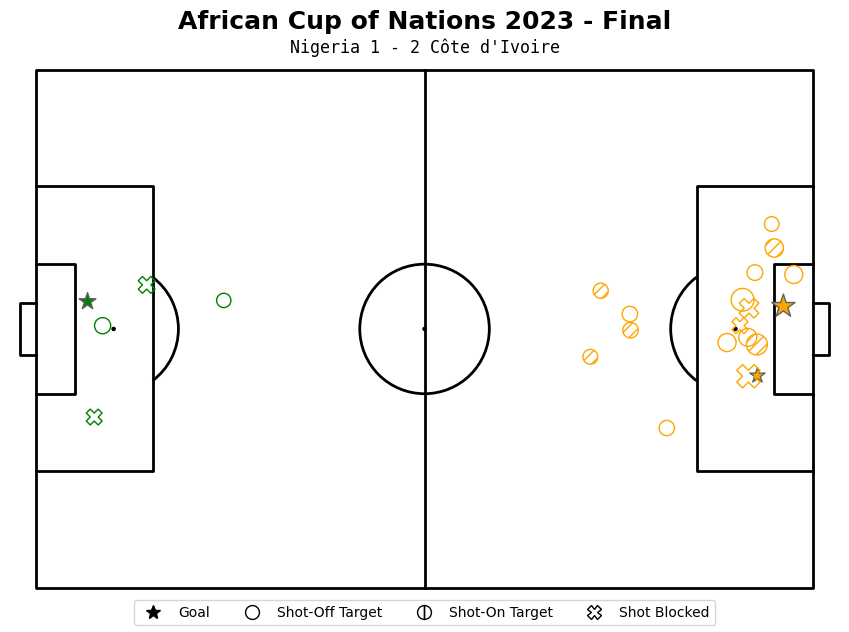

In [ ]:
from matplotlib.lines import Line2D
from mplsoccer.utils import add_image



pitch = Pitch(goal_type='box',line_color='black')
fig, ax = pitch.draw(figsize=(9,6))
sc1 = pitch.scatter(shots[(shots['team_name']=='Nigeria')&(shots['outcome_name']=='Goal')]['x'], 80-shots[(shots['team_name']=='Nigeria')&(shots['outcome_name']=='Goal')]['y'],
                    s=(shots[(shots['team_name']=='Nigeria')&(shots['outcome_name']=='Goal')]['shot_statsbomb_xg'] * 900)+100,
                    edgecolors='#606060',
                    c='green',
                    marker='*',
                    ax=ax)
sc11 = pitch.scatter(shots[(shots['team_name']=="Nigeria")&(shots['outcome_name']=='Saved')]['x'], 80-shots[(shots['team_name']=="Nigeria")&(shots['outcome_name']=='Saved')]['y'],
                    s=(shots[(shots['team_name']=="Nigeria")&(shots['outcome_name']=='Saved')]['shot_statsbomb_xg'] * 900)+100,
                    edgecolors='green',
                    hatch= '///',
                    c='None',
                    marker='o',
                    ax=ax)
sc12 = pitch.scatter(shots[(shots['team_name']=='Nigeria')&(shots['outcome_name']=="Off T")|(shots['team_name']=='Nigeria')&(shots['outcome_name']=='Wayward')]['x'], 80-shots[(shots['team_name']=='Nigeria')&(shots['outcome_name']=="Off T")|(shots['team_name']=='Nigeria')&(shots['outcome_name']=='Wayward')]['y'],
                    s=(shots[(shots['team_name']=='Nigeria')&(shots['outcome_name']=="Off T")|(shots['team_name']=='Nigeria')&(shots['outcome_name']=='Wayward')]['shot_statsbomb_xg'] * 400)+100,
                    edgecolors='green',
                    c='None',
                    marker='o',
                    ax=ax)
sc13 = pitch.scatter(shots[(shots['team_name']=="Nigeria")&(shots['outcome_name']=='Blocked')]['x'], 80-shots[(shots['team_name']=="Nigeria")&(shots['outcome_name']=='Blocked')]['y'],
                    s=(shots[(shots['team_name']=="Nigeria")&(shots['outcome_name']=='Blocked')]['shot_statsbomb_xg'] * 900)+100,
                    edgecolors='green',
                    c='None',
                    marker='X',
                    ax=ax)



sc2 = pitch.scatter(shots[(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=='Goal')]['x'], shots[(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=='Goal')]['y'],
                    s=(shots[(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=='Goal')]['shot_statsbomb_xg'] * 900)+100,
                    edgecolors='#606060',
                    c='orange',
                    marker='*',
                    ax=ax)
sc21 = pitch.scatter(shots[(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=='Saved')]['x'], shots[(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=='Saved')]['y'],
                    s=(shots[(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=='Saved')]['shot_statsbomb_xg'] * 900)+100,
                    edgecolors='orange',
                    hatch= '///',
                    c='None',
                    marker='o',
                    ax=ax)
sc22 = pitch.scatter(shots[(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=="Off T")|(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=='Wayward')]['x'], shots[(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=="Off T")|(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=='Wayward')]['y'],
                    s=(shots[(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=="Off T")|(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=='Wayward')]['shot_statsbomb_xg'] * 900)+100,
                    edgecolors='orange',
                    c='None',
                    marker='o',
                    ax=ax)
sc23 = pitch.scatter(shots[(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=='Blocked')]['x'], shots[(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=='Blocked')]['y'],
                    s=(shots[(shots['team_name']=="Côte d'Ivoire")&(shots['outcome_name']=='Blocked')]['shot_statsbomb_xg'] * 900)+100,
                    edgecolors='orange',
                    c='None',
                    marker='X',
                    ax=ax)
from matplotlib.lines import Line2D
point1 = Line2D([0], [0], label='Goal', marker='*', markersize=10,
         markeredgecolor='black', markerfacecolor='black', linestyle='')
point2 = Line2D([0], [0], label='Shot-Off Target', marker='o', markersize=10,
         markeredgecolor='black', markerfacecolor='None', linestyle='')
point3 = Line2D([0], [0], label='Shot-On Target', marker='o', markersize=10,
         markeredgecolor='black', markerfacecolor='None', linestyle='',fillstyle='left')
point4 = Line2D([0], [0], marker='X', markersize=10,label='Shot Blocked',
         markeredgecolor='black', markerfacecolor='None', linestyle='')

fig.legend(handles=[point1,point2,point3,point4],ncols=4,loc='lower center')

fig.text(s=f'African Cup of Nations 2023 - Final',x=0.5,y=1,fontsize=18,fontweight="bold",ha='center')
fig.text(s="Nigeria 1 - 2 Côte d'Ivoire",x=0.5,y=.96,fontsize=12,ha='center',fontfamily='monospace')
# plt.savefig(f'{base_dir}final_afcon_shotmap.png',bbox_inches='tight')

# Pass Map

In [ ]:
df.columns

Index(['index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'type_name', 'possession_team_name', 'play_pattern_name',
       'team_name', 'tactics_formation', 'player_id', 'player_name',
       'position_name', 'pass_recipient_name', 'pass_length', 'pass_angle',
       'pass_height_name', 'end_x', 'end_y', 'body_part_name', 'sub_type_name',
       'x', 'y', 'under_pressure', 'outcome_name', 'aerial_won', 'off_camera',
       'counterpress', 'pass_switch', 'foul_won_defensive',
       'pass_assisted_shot_id', 'pass_shot_assist', 'shot_statsbomb_xg',
       'shot_key_pass_id', 'technique_name', 'goalkeeper_position_name',
       'pass_cross', 'end_z', 'shot_first_time', 'dribble_overrun',
       'ball_recovery_recovery_failure', 'out', 'dribble_nutmeg',
       'ball_recovery_offensive', 'foul_committed_advantage',
       'foul_won_advantage', 'shot_one_on_one', 'injury_stoppage_in_chain',
       'block_offensive', 'foul_committed_offensive', 'bad_behaviour

In [ ]:
passes = df[(df['type_name']=='Pass')&(df['play_pattern_name']!='From Throw In')]

In [ ]:
lineup_team = df[df['team_name']=='Nigeria'][['player_name','player_id']].dropna(how='any',axis='rows')

In [ ]:
num_players = lineup_team.player_name.nunique()

In [ ]:
lineup_team = lineup_team.drop_duplicates(keep='first').reset_index(drop=True)

In [ ]:
team1 = df['team_name'].unique()[0]
team2 = df['team_name'].unique()[1]

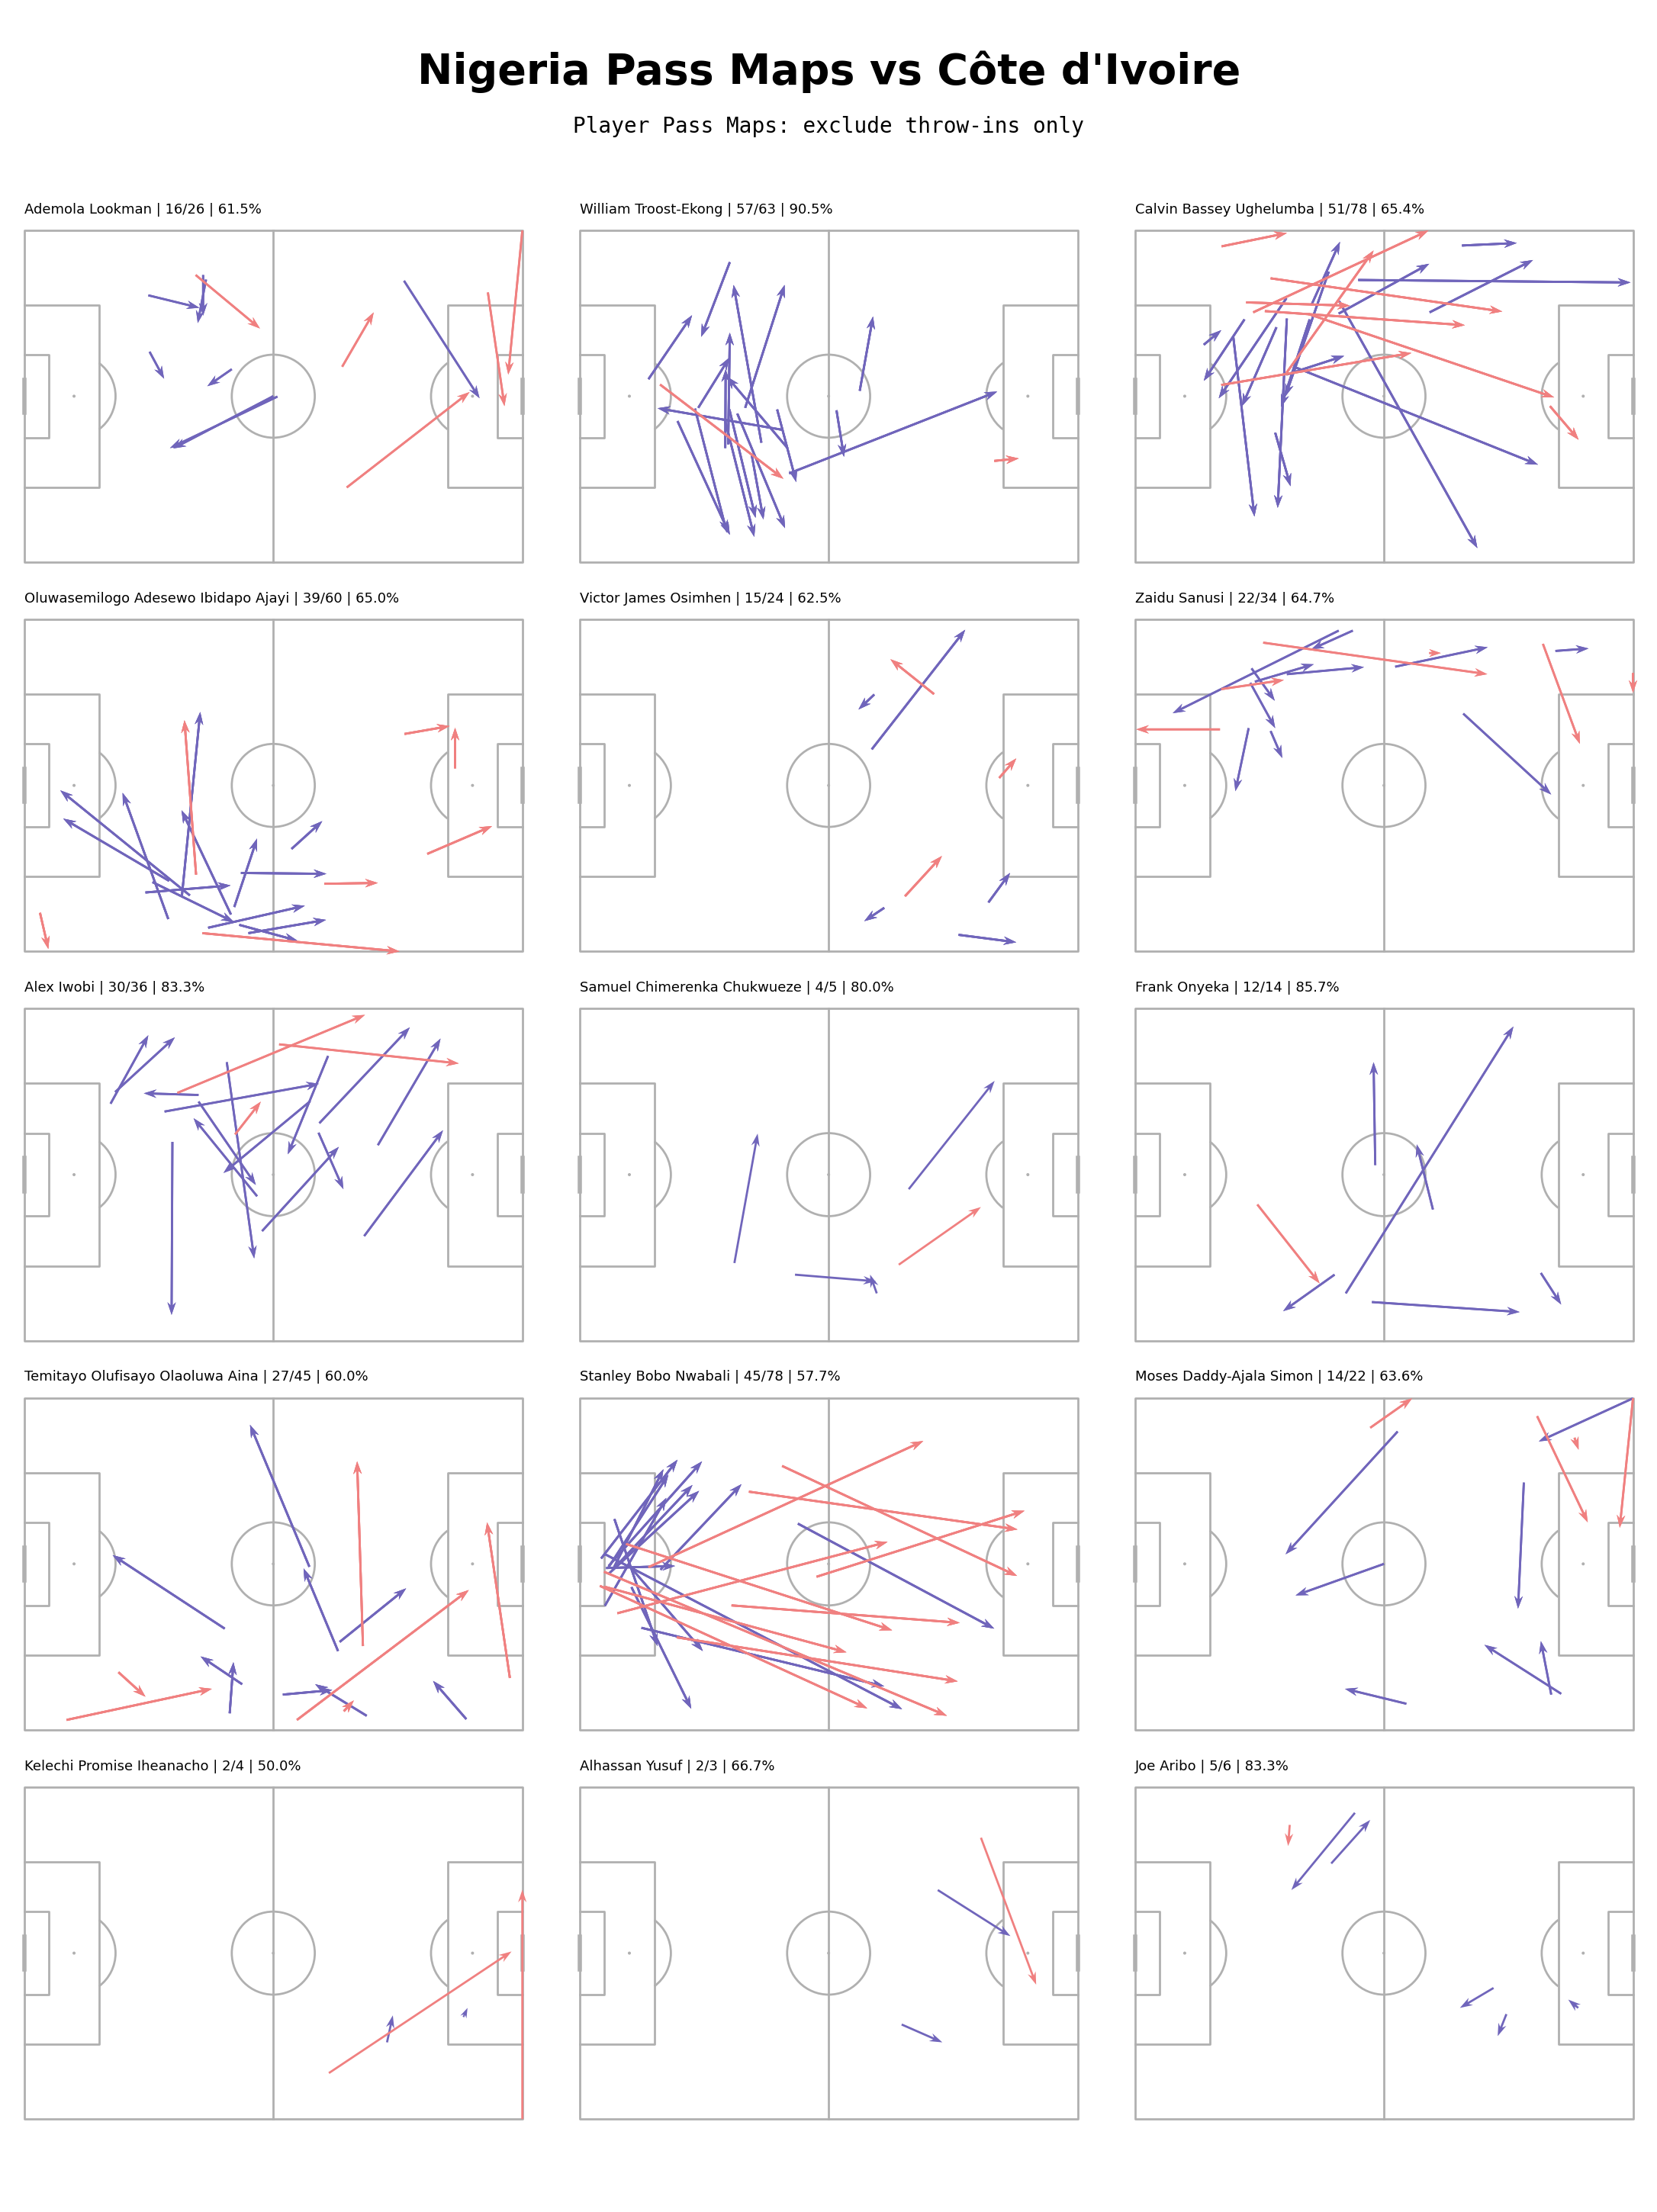

In [ ]:
# plot the 5 * 3 grid
pitch = Pitch()
fig, axs = pitch.grid(nrows=5, ncols=3, figheight=30,
                      endnote_height=0.03, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_height=0.08, grid_height=0.84)
# cycle through the grid axes and plot the player pass maps
for idx, ax in enumerate(axs['pitch'].flat):
        # filter the complete/incomplete passes for each player (excudes throw-ins)
        lineup_player = lineup_team.iloc[idx]
        player_id = lineup_player.player_id
        player_pass = passes[passes.player_id == player_id]
        complete_pass = player_pass[player_pass.outcome_name.isnull()]
        incomplete_pass = player_pass[player_pass.outcome_name.notnull()]

        # plot the arrows
        pitch.arrows(complete_pass.x, complete_pass.y,
                     complete_pass.end_x, complete_pass.end_y,
                     color='#7065bb', width=2, headwidth=4, headlength=6, ax=ax)
        pitch.arrows(incomplete_pass.x, incomplete_pass.y,
                     incomplete_pass.end_x, incomplete_pass.end_y,
                     color='lightcoral', width=2, headwidth=4, headlength=6, ax=ax)

        total_pass = len(complete_pass) + len(incomplete_pass)
        annotation_string = (f'{lineup_player.player_name} | '
                             f'{len(complete_pass)}/{total_pass} | '
                             f'{round(100 * len(complete_pass)/total_pass, 1)}%')
        ax.text(0, -5, annotation_string, ha='left', va='center', fontsize=13)



# title text
axs['title'].text(0.5, 0.65, f'{team1} Pass Maps vs {team2}', fontsize=40, va='center', ha='center',fontweight='bold')
SUB_TEXT = ('Player Pass Maps: exclude throw-ins only')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=20, va='center', ha='center',fontfamily='monospace')

plt.savefig(f"{base_dir}Nigeria_passMaps.png",bbox_inches='tight')

plt.show()  # If you are using a Jupyter notebook you do not need this line

In [ ]:
lineup_team2 = df[df['team_name']==team2][['player_name','player_id']].dropna(how='any',axis='rows')
lineup_team2 = lineup_team2.drop_duplicates(keep='first').reset_index(drop=True)
num_players2 = len(lineup_team2.player_name)

In [ ]:
lineup_team2

,player_name,player_id
0,Obite Evan Ndicka,7713.0
1,Yahia Fofana,36629.0
2,Ghislain Konan,10039.0
3,Odilon Kossonou,27133.0
4,Simon Adingra,105392.0
5,Max-Alain Gradel,4416.0
6,Jean Michaël Seri,3359.0
7,Seko Fofana,7791.0
8,Serge Aurier,3481.0
9,Sébastien Haller,8673.0


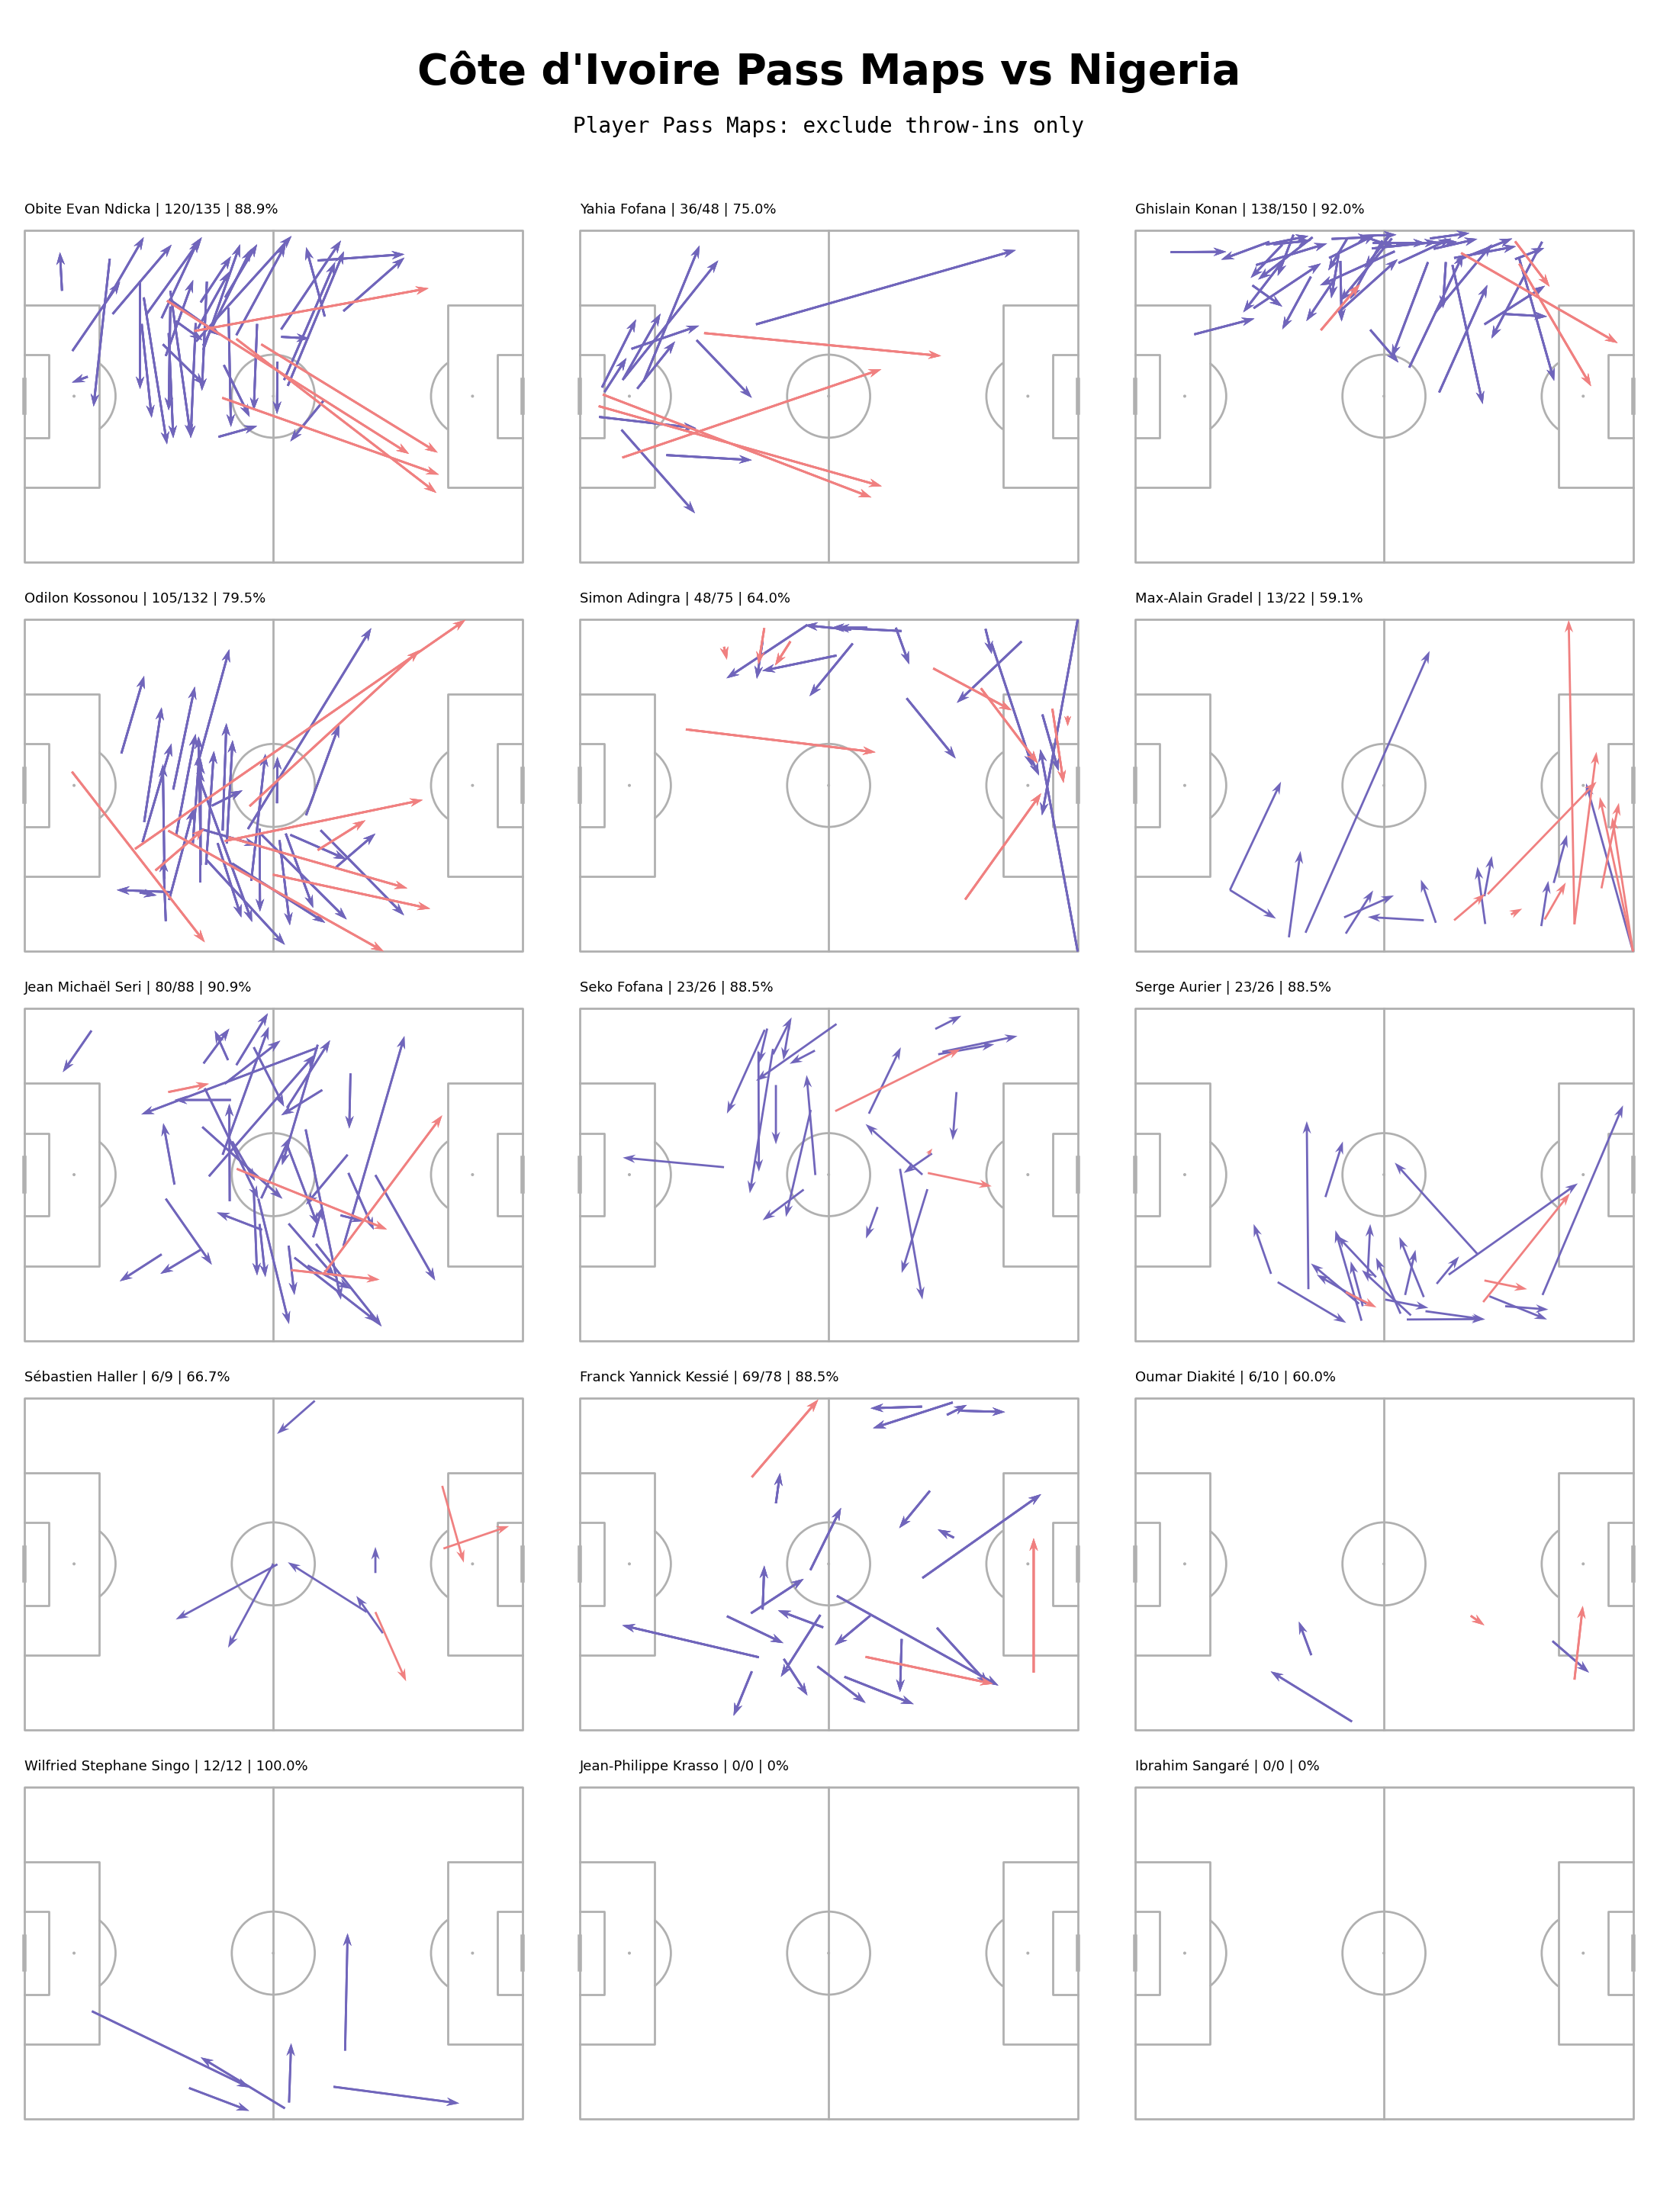

In [ ]:
# plot the 5 * 3 grid
pitch = Pitch()
fig, axs = pitch.grid(nrows=5, ncols=3, figheight=30,
                      endnote_height=0.03, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_height=0.08, grid_height=0.84)
# cycle through the grid axes and plot the player pass maps
for idx, ax in enumerate(axs['pitch'].flat):
        # filter the complete/incomplete passes for each player (excudes throw-ins)
        lineup_player = lineup_team2.iloc[idx]
        player_id = lineup_player.player_id
        player_pass = passes[passes.player_id == player_id]
        complete_pass = player_pass[player_pass.outcome_name.isnull()]
        incomplete_pass = player_pass[player_pass.outcome_name.notnull()]

        # plot the arrows
        pitch.arrows(complete_pass.x, complete_pass.y,
                     complete_pass.end_x, complete_pass.end_y,
                     color='#7065bb', width=2, headwidth=4, headlength=6, ax=ax)
        pitch.arrows(incomplete_pass.x, incomplete_pass.y,
                     incomplete_pass.end_x, incomplete_pass.end_y,
                     color='lightcoral', width=2, headwidth=4, headlength=6, ax=ax)

        total_pass = len(complete_pass) + len(incomplete_pass)

        annotation_string = (f'{lineup_player.player_name} | '
                             f'{len(complete_pass)}/{total_pass} | '
                             f'{round(100 * len(complete_pass)/total_pass, 1) if total_pass > 1 else 0}%')
        ax.text(0, -5, annotation_string, ha='left', va='center', fontsize=13)



# title text
axs['title'].text(0.5, 0.65, f'{team2} Pass Maps vs {team1}', fontsize=40, va='center', ha='center',fontweight='bold')
SUB_TEXT = ('Player Pass Maps: exclude throw-ins only')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=20, va='center', ha='center',fontfamily='monospace')

# plt.savefig(f"{base_dir}{team2}_passMaps.png",bbox_inches='tight')

plt.show()  # If you are using a Jupyter notebook you do not need this line

In [ ]:
passes_ngr_s = passes[(passes['team_name']==team1)&(passes['end_x']>102)&(passes['end_y']<62)&(passes['end_y']>18)&(passes['outcome_name']=='Completed')].drop_duplicates()
passes_ic_s = passes[(passes['team_name']==team2)&(passes['end_x']>102)&(passes['end_y']<62)&(passes['end_y']>18)&(passes['outcome_name']=='Completed')].drop_duplicates()
passes_ngr = passes[(passes['team_name']==team1)&(passes['end_x']>102)&(passes['end_y']<62)&(passes['end_y']>18)&(passes['outcome_name']!='Completed')].drop_duplicates()
passes_ic = passes[(passes['team_name']==team2)&(passes['end_x']>102)&(passes['end_y']<62)&(passes['end_y']>18)&(passes['outcome_name']!='Completed')].drop_duplicates()

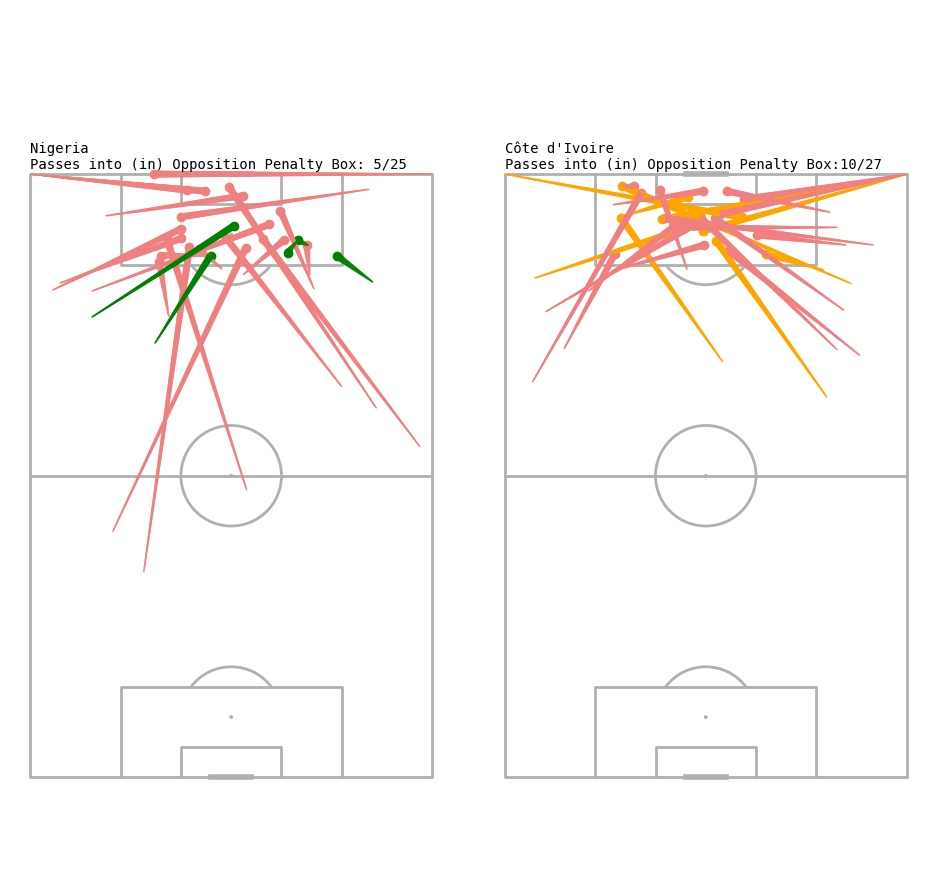

In [ ]:
pitch = VerticalPitch()
fig,axs = pitch.grid(nrows=1,ncols=2,axis=False)
#incomplete passes
pitch.lines(passes_ngr['x'],passes_ngr['y'],passes_ngr['end_x'],passes_ngr['end_y'],comet=True,ax=axs['pitch'][0],color='lightcoral')
pitch.scatter(passes_ngr['end_x'],passes_ngr['end_y'],ax=axs['pitch'][0],color='lightcoral')
#completed
pitch.lines(passes_ngr_s['x'],passes_ngr_s['y'],passes_ngr_s['end_x'],passes_ngr_s['end_y'],comet=True,ax=axs['pitch'][0],color='green')
pitch.scatter(passes_ngr_s['end_x'],passes_ngr_s['end_y'],ax=axs['pitch'][0],color='green')
#text
axs['pitch'][0].text(x=0,y=121,s=f'{team1} \nPasses into (in) Opposition Penalty Box: {len(passes_ngr_s)}/{len(passes_ngr)+len(passes_ngr_s)}',fontfamily='monospace')

#completed
pitch.lines(passes_ic_s['x'],passes_ic_s['y'],passes_ic_s['end_x'],passes_ic_s['end_y'],comet=True,ax=axs['pitch'][1],color='orange')
pitch.scatter(passes_ic_s['end_x'],passes_ic_s['end_y'],ax=axs['pitch'][1],color='orange')

pitch.lines(passes_ic['x'],passes_ic['y'],passes_ic['end_x'],passes_ic['end_y'],comet=True,ax=axs['pitch'][1],color='lightcoral')
pitch.scatter(passes_ic['end_x'],passes_ic['end_y'],ax=axs['pitch'][1],color='lightcoral')
axs['pitch'][1].text(x=0,y=121,s=f'{team2} \nPasses into (in) Opposition Penalty Box:{len(passes_ic_s)}/{len(passes_ic)+len(passes_ic_s)}',fontfamily='monospace')
# plt.savefig(f"{base_dir}Passes_into_penalty.png",bbox_inches='tight')

# Expected Threat

In [ ]:
xT = pd.read_csv(f"{base_dir}xT_Grid.csv",header=None)

In [ ]:
xt = np.array(xT)

In [ ]:
xt_rows, xt_cols = xt.shape

In [ ]:
xt_cols

12

In [ ]:
bin_df = df.loc[(df['x'].isna()==False)&(df['y'].isna()==False)&(df['end_x'].isna()==False)&(df['end_y'].isna()==False),\
              ['period','minute','team_name','player_name','type_name','sub_type_name','outcome_name','x','y','end_x','end_y']].reset_index(drop=True)

In [ ]:
bin_df['x1_bin'] = pd.cut(bin_df['x'],bins=xt_cols,labels=False)
bin_df['x2_bin'] = pd.cut(bin_df['end_x'],bins=xt_cols,labels=False)
bin_df['y1_bin'] = pd.cut(bin_df['y'],bins=xt_rows,labels=False)
bin_df['y2_bin'] = pd.cut(bin_df['end_y'],bins=xt_rows,labels=False)

In [ ]:
def start_value(s1,s2):
  return xt[s1][s2]

In [ ]:
bin_df['start_xt_value'] = [start_value(x,y) for x,y in zip(bin_df['y1_bin'],bin_df['x1_bin'])]

In [ ]:
bin_df['end_xt_value'] = [start_value(x,y) for x,y in zip(bin_df['y2_bin'],bin_df['x2_bin'])]

In [ ]:
bin_df['xt'] = bin_df['end_xt_value'] - bin_df['start_xt_value']

In [ ]:
xt_chart = bin_df.groupby(['minute','team_name'])['xt'].sum().reset_index()

In [ ]:
xt_chart

,minute,team_name,xt
0,0,Côte d'Ivoire,0.066574
1,0,Nigeria,0.740482
2,1,Côte d'Ivoire,0.055160
3,1,Nigeria,0.034332
4,2,Côte d'Ivoire,0.027879
...,...,...,...
144,94,Nigeria,0.024013
145,95,Côte d'Ivoire,0.024309
146,95,Nigeria,0.516615
147,96,Côte d'Ivoire,0.066477


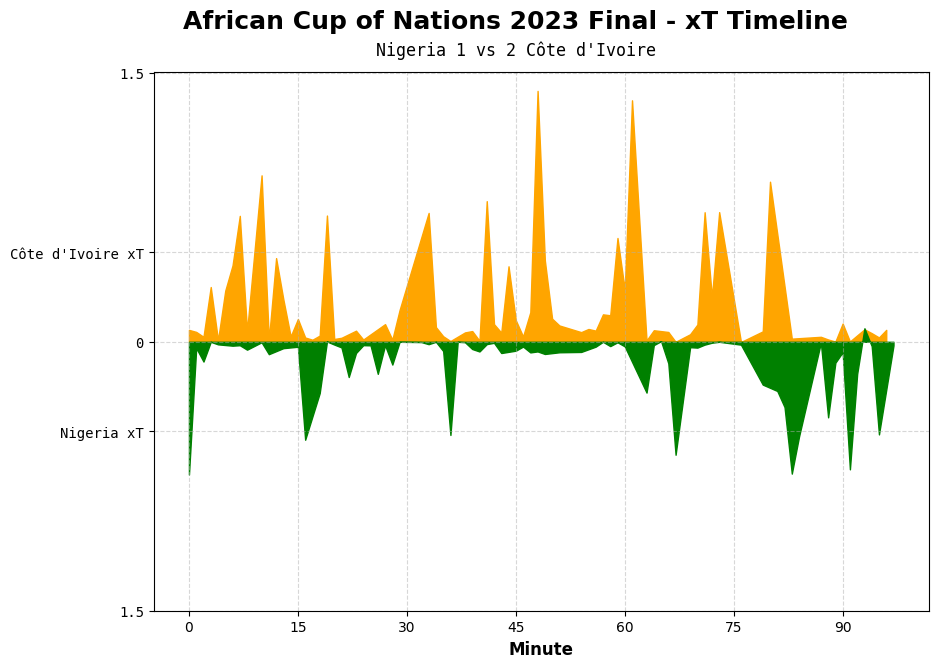

In [ ]:
plt.figure(figsize=(10,7))
plt.grid(linestyle='--',alpha=.5)
plt.text(x=45,y=1.75,s='African Cup of Nations 2023 Final - xT Timeline',fontsize=18,fontweight='bold',ha='center')
plt.text(x=45,y=1.6,s="Nigeria 1 vs 2 Côte d'Ivoire",fontsize=12,fontfamily='monospace',ha='center')

plt.fill_between(xt_chart.loc[xt_chart['team_name']=="Côte d'Ivoire",'minute'],xt_chart.loc[xt_chart['team_name']=="Côte d'Ivoire",'xt'],color='orange')
plt.fill_between(xt_chart.loc[xt_chart['team_name']=="Nigeria",'minute'],-xt_chart.loc[xt_chart['team_name']=="Nigeria",'xt'],color='green')

plt.xlabel('Minute',fontsize=12,fontweight='bold')
plt.xticks([a for a in range(0,105,15)])
plt.yticks([-1.5,-.5,0,.5,1.5],[1.5,'Nigeria xT' ,0, 'Côte d\'Ivoire xT',1.5],fontfamily='monospace')
# plt.savefig(f'{base_dir}xT-final-afcon.png',bbox_inches='tight')
plt.show()

# Individual

In [ ]:
def_action = ['Clearance','Block','Interception','Duel','Tackle']
defend = df[(df['type_name']==def_action[0])|(df['type_name']==def_action[1])|(df['type_name']==def_action[2])|(df['type_name']==def_action[3])|(df['sub_type_name']==def_action[4])]

In [ ]:
ngr_df_line = df.loc[(df['player_name']=='William Troost-Ekong')|(df['player_name']=='Calvin Bassey Ughelumba')|(df['player_name']=='Oluwasemilogo Adesewo Ibidapo Ajayi'),'x'].mean()
ic_df_line = df.loc[(df['player_name']=='Obite Evan Ndicka')|(df['player_name']=='Ghislain Konan')|(df['player_name']=='Serge Aurier')|(df['player_name']=='Odilon Kossonou'),'x'].mean()

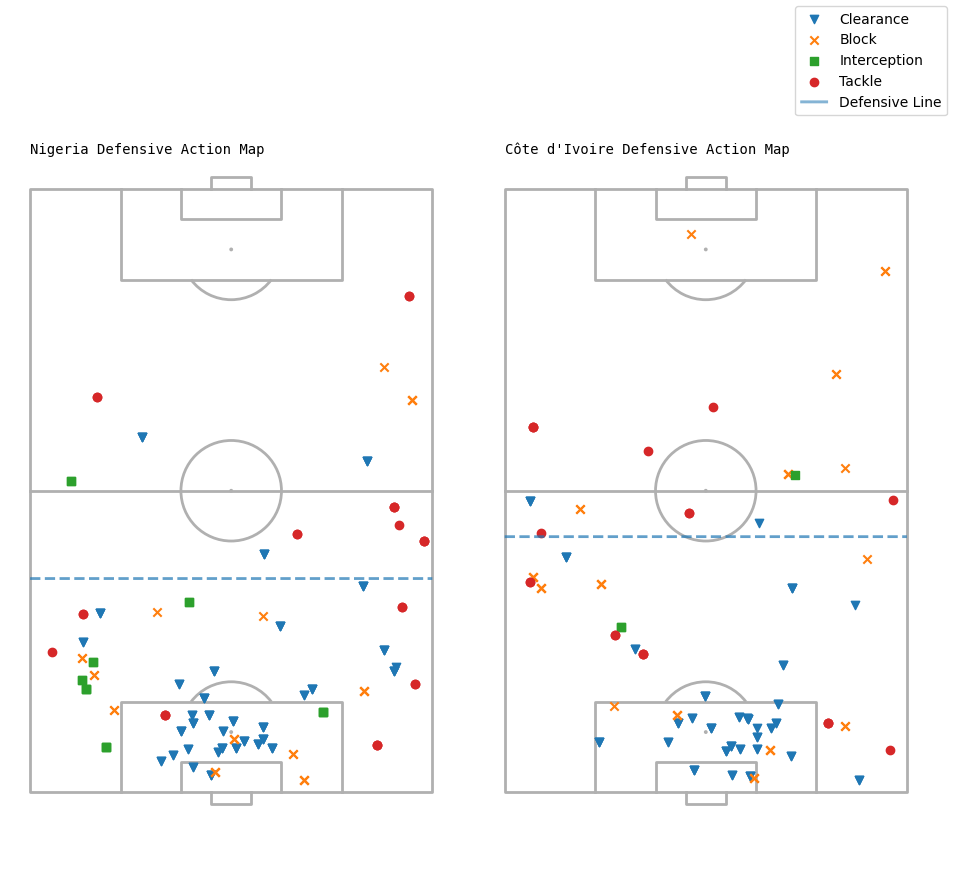

In [ ]:
pitch = VerticalPitch(goal_type='box')
fig,axs = pitch.grid(nrows=1,ncols=2,axis=False)
#clearance
pitch.scatter(x=defend.loc[(defend['type_name']==def_action[0])&(defend['team_name']==team1),'x'],y=defend.loc[(defend['type_name']==def_action[0])&(defend['team_name']==team1),'y'],marker='v',ax=axs['pitch'][0],label='Clearance')
#block
pitch.scatter(x=defend.loc[(defend['type_name']==def_action[1])&(defend['team_name']==team1),'x'],y=defend.loc[(defend['type_name']==def_action[1])&(defend['team_name']==team1),'y'],marker='x',ax=axs['pitch'][0],label='Block')
#interception
pitch.scatter(x=defend.loc[(defend['type_name']==def_action[2])&(defend['team_name']==team1),'x'],y=defend.loc[(defend['type_name']==def_action[2])&(defend['team_name']==team1),'y'],marker='s',ax=axs['pitch'][0],label='Interception')
#tackle
pitch.scatter(x=defend.loc[(defend['sub_type_name']==def_action[4])&(defend['team_name']==team1),'x'],y=defend.loc[(defend['sub_type_name']==def_action[4])&(defend['team_name']==team1),'y'],marker='o',ax=axs['pitch'][0],label='Tackle')
#defensive line
pitch.lines(ngr_df_line,0,ngr_df_line,80,ax=axs['pitch'][0],lw=2,linestyle='--',alpha=.7,label='Defensive Line')
#text
axs['pitch'][0].text(x=0,y=127,s=f'{team1} Defensive Action Map',fontfamily='monospace')

#clearance
pitch.scatter(x=defend.loc[(defend['type_name']==def_action[0])&(defend['team_name']==team2),'x'],y=defend.loc[(defend['type_name']==def_action[0])&(defend['team_name']==team2),'y'],marker='v',ax=axs['pitch'][1],label='Clearance')
#block
pitch.scatter(x=defend.loc[(defend['type_name']==def_action[1])&(defend['team_name']==team2),'x'],y=defend.loc[(defend['type_name']==def_action[1])&(defend['team_name']==team2),'y'],marker='x',ax=axs['pitch'][1],label='Block')
#interception
pitch.scatter(x=defend.loc[(defend['type_name']==def_action[2])&(defend['team_name']==team2),'x'],y=defend.loc[(defend['type_name']==def_action[2])&(defend['team_name']==team2),'y'],marker='s',ax=axs['pitch'][1],label='Interception')
#tackle
pitch.scatter(x=defend.loc[(defend['sub_type_name']==def_action[4])&(defend['team_name']==team2),'x'],y=defend.loc[(defend['sub_type_name']==def_action[4])&(defend['team_name']==team2),'y'],marker='o',ax=axs['pitch'][1],label='Tackle')
#defensive line
pitch.lines(ic_df_line,0,ic_df_line,80,ax=axs['pitch'][1],lw=2,linestyle='--',alpha=.7,label='Defensive Line')
#text
axs['pitch'][1].text(x=0,y=127,s=f'{team2} Defensive Action Map',fontfamily='monospace')


h, l = axs['pitch'][0].get_legend_handles_labels()
fig.legend(h,l)

# plt.savefig(f"{base_dir}-def-action-map.png",bbox_inches='tight')

In [ ]:
motm = df[df['player_name']=='Simon Adingra']

In [ ]:
motm

,index,period,timestamp,minute,second,possession,duration,type_name,possession_team_name,play_pattern_name,...,injury_stoppage_in_chain,block_offensive,foul_committed_offensive,bad_behaviour_card_id,bad_behaviour_card_name,substitution_replacement_name,pass_goal_assist,pass_cut_back,foul_committed_card_name,jersey_number
99,37,1,00:00:38.840000,0,38,3,NaN,Ball Receipt,Côte d'Ivoire,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
100,37,1,00:00:38.840000,0,38,3,NaN,Ball Receipt,Côte d'Ivoire,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
101,37,1,00:00:38.840000,0,38,3,NaN,Ball Receipt,Côte d'Ivoire,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
102,38,1,00:00:38.840000,0,38,3,1.552286,Pass,Côte d'Ivoire,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
103,38,1,00:00:38.840000,0,38,3,1.552286,Pass,Côte d'Ivoire,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5888,2542,2,00:45:54.612000,90,54,154,0.255860,Pass,Côte d'Ivoire,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
5889,2542,2,00:45:54.612000,90,54,154,0.255860,Pass,Côte d'Ivoire,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
6158,2674,2,00:50:38.545000,95,38,161,NaN,Ball Receipt,Nigeria,From Free Kick,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
6159,2674,2,00:50:38.545000,95,38,161,NaN,Ball Receipt,Nigeria,From Free Kick,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0
